<a href="https://colab.research.google.com/github/vigneshK0404/NOva_Fitter_CNF/blob/main/CNF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo
!pip install nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=86dd5b2227c384f2873727c057e2e7dbdb415b2fc96baad60be42ebee8007e5b
  Stored in directory: /root/.cache/pip/wheels/fd/27/c3/8952205ea17b63dc1eaa24031e63111c6a3661cb22cc1e2a3c
Successfully built nflows


In [2]:
import torch
import torchinfo
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader
import time

In [3]:
from nflows.flows.base import Flow  # a container for full Flow
from nflows.distributions.normal import StandardNormal  # Gaussian latent space distribution
from nflows.transforms.base import (
    CompositeTransform,
)  # a wrapper to stack simpler transformations to form a more complex one
from nflows.transforms.autoregressive import (
    MaskedAffineAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.autoregressive import (
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.permutations import ReversePermutation # a layer that simply reverts the order of outputs

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
dnumber = 0
device = torch.device(f"cuda:{dnumber}" if torch.cuda.is_available() else "cpu")
print(device)
device_name = torch.cuda.get_device_name(dnumber)
print(device_name)

True
1
cuda:0
NVIDIA A100-SXM4-80GB


In [27]:
def gauss(N,mu,sig,x):
    N_t = N.reshape(-1,1)
    mu_t = mu.reshape(-1,1)
    sig_t = sig.reshape(-1,1)

    term1 = N_t / (sig_t * np.sqrt(2 * np.pi))
    term2 = np.exp(-0.5 * np.square((x - mu_t) / sig_t))
    return np.array(term1 * term2)


def generatePrior(sampleSize):
    N1 = np.random.uniform(10,50,sampleSize)
    N2 = np.random.uniform(10,30,sampleSize)

    mu1 = np.random.uniform(1,3,sampleSize)
    mu2 = np.random.uniform(5,9,sampleSize)

    sig1 = np.random.uniform(1,3,sampleSize)
    sig2 = np.random.uniform(5,9,sampleSize)

    return N1,mu1,sig1,N2,mu2,sig2


def generateTrainingData(sampleNumber):
  N1,mu1,sig1,N2,mu2,sig2 = generatePrior(sampleNumber)

  raw = np.arange(0.5,10,1) #startbinCenter, endBinEdge, StepSize [0.5,1.5...9.5]
  gaussTotal = gauss(N1,mu1,sig1,raw) + gauss(N2,mu2,sig2,raw)

  binNumber = len(gaussTotal)
  dataPoisson = np.random.poisson(lam=gaussTotal,size=None)

  thetaData = np.column_stack((N1,mu1,sig1,N2,mu2,sig2))
  return dataPoisson, thetaData

dataPoisson, thetaData = generateTrainingData(10000000)

I am going to normalize the data using min-max I can preserve the relationships while keeping it ideal for sigmoid to take part perhaps. I also found appraches involving log, if this does not work I will look into that.

In [30]:
print(dataPoisson.shape, thetaData.shape)
max_vals = torch.tensor(np.max(dataPoisson, axis = 0))
min_vals = torch.tensor(np.min(dataPoisson, axis = 0))

input_p = torch.tensor(dataPoisson,dtype=torch.float32)

(10000000, 10) (10000000, 6)


We may have to rethink structure of data storage for CNF later. But for now the autoencoder simply needs to take the 10-D output in and minimize loss.

In [31]:
from torch.nn.modules.activation import Softmax
from nflows.transforms.nonlinearities import Sigmoid

class autoEncoder(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim,min_data,max_data):
    super().__init__()

    #self.max = torch.nn.Parameter(max_vals,requires_grad=False)
    #self.min = torch.nn.Parameter(min_vals,requires_grad=False)

    self.register_buffer("min", min_data)
    self.register_buffer("max", max_data)



    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,hidden_dim),
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(hidden_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,input_dim),
        torch.nn.Sigmoid()
    )

  def encode(self,x):
    x = (x-self.min)/(self.max - self.min + 1e-8)
    return self.encoder(x)

  def decode(self,x):
    dData = self.decoder(x)
    return dData*(self.max - self.min) + self.min

  def forward(self,x):
    eData = self.encode(x)
    dData = self.decode(eData)
    return dData

In [32]:
class CNF():
  def __init__(self,n_features, context_features,n_layers):

    base_dist = StandardNormal(shape=[n_features])
    transforms = []

    for i in range(n_layers):
      transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, hidden_features=16, context_features=6)) #we are conditioning on 6 column data Ni,MUi and Stdi i{1,2}
      transforms.append(ReversePermutation(features=n_features))

    transform = CompositeTransform(transforms)
    self.flow = Flow(transform,base_dist)




In [33]:
input_dim = 10
n_features = 6 #doubles as hidden_dim
contextF = 6 #N1,N2,mu1,mu2,sig1,sig2
n_layers = 10

encodeModel = autoEncoder(input_dim,n_features,min_data=min_vals,max_data=max_vals).to(device)
reconOptim = torch.optim.Adam(encodeModel.parameters(), lr = 1e-4)
print(torchinfo.summary(encodeModel))
rloss = torch.nn.MSELoss()


Layer (type:depth-idx)                   Param #
autoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       198
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       224
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       330
│    └─Sigmoid: 2-7                      --
Total params: 1,104
Trainable params: 1,104
Non-trainable params: 0
Layer (type:depth-idx)                                       Param #
Flow                                                         --
├─CompositeTransform: 1-1                                    --
│    └─ModuleList: 2-1                                       --
│    │    └─MaskedAffineAutoregressiveTransform: 3-1         1,740
│    │    └─ReversePermutation: 3-2                          --
│    │    └─MaskedAffineAutoregressiveTransform

100%|██████████| 6/6 [03:59<00:00, 39.86s/it]

6


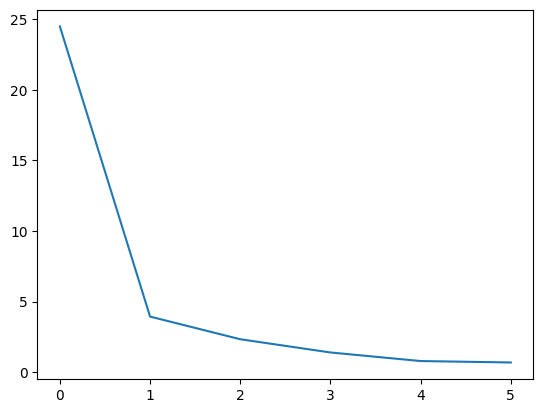

In [34]:
max_iter = 5
r_losses = []
Datasets = DataLoader(dataPoisson, batch_size = 4096, shuffle=True)

for iter in tqdm.tqdm(range(max_iter)):
  iter_losses = []
  for x_batch in Datasets:
      x_batch = x_batch.to(device, non_blocking=True).float()
      reconOptim.zero_grad()
      y_pred = encodeModel(x_batch)
      loss = rloss(y_pred, x_batch)
      iter_losses.append(loss.item())
      loss.backward()
      reconOptim.step()

  r_losses.append(np.mean(np.array(iter_losses)))

print(len(r_losses))
plt.plot(r_losses)


In [35]:
print(r_losses[-1])

0.6833838981062931


[ 2.515111  14.322969  13.809822   4.8863425  1.9054425  1.2151165
  0.9809747  1.0104941  1.0431905  1.0245063]
[ 2. 14. 14.  5.  2.  0.  3.  0.  1.  3.]


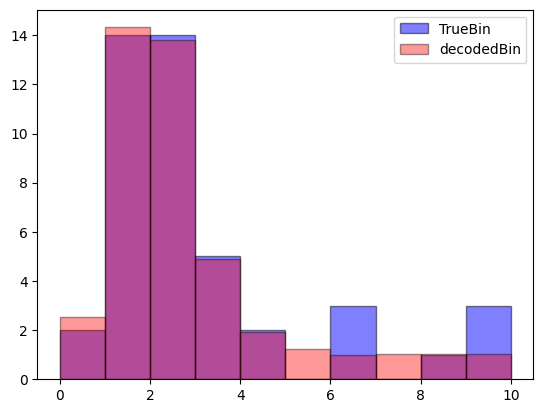

In [36]:
testP,_ = generateTrainingData(1)
testP = torch.tensor(testP, dtype = torch.float32)
testP = testP.to(device)
decodePtest = encodeModel(testP).to("cpu").detach().numpy().flatten()
testP_CPU = testP.to("cpu").detach().numpy().flatten()

print(decodePtest)
print(testP_CPU)

bins = np.array(range(11))
plt.hist(bins[:-1], bins,weights=testP_CPU,color='blue',edgecolor='black',alpha=0.5,label="TrueBin")
plt.hist(bins[:-1], bins,weights=decodePtest,color='red',edgecolor='black',alpha=0.4,label="decodedBin")
plt.legend()

In [59]:
CNFModel = CNF(n_features,context_features= contextF,n_layers=10).flow.to(device)
flowOptim = torch.optim.Adam(CNFModel.parameters(), lr = 1e-4)

print(torchinfo.summary(CNFModel))

Layer (type:depth-idx)                                       Param #
Flow                                                         --
├─CompositeTransform: 1-1                                    --
│    └─ModuleList: 2-1                                       --
│    │    └─MaskedAffineAutoregressiveTransform: 3-1         1,740
│    │    └─ReversePermutation: 3-2                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-3         1,740
│    │    └─ReversePermutation: 3-4                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-5         1,740
│    │    └─ReversePermutation: 3-6                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-7         1,740
│    │    └─ReversePermutation: 3-8                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-9         1,740
│    │    └─ReversePermutation: 3-10                         --
│    │    └─MaskedAffineAutoregressiveTransform: 3-11        1,740
│    │    └─Rever

In [60]:
batch_size = 512
num_iter = 5 #reduce number of iterations this converges a lot quicker

max_batch = int(dataPoisson.shape[0] / batch_size)

logLoss = []

for i in tqdm.tqdm(range(num_iter)):
  permut = np.random.permutation(dataPoisson.shape[0])
  dataPoisson_shufle = dataPoisson[permut]
  thetaData_shuffle = thetaData[permut]

  for i_batch in range(max_batch):
    start = i_batch * batch_size
    end = start + batch_size

    pData = torch.tensor(dataPoisson_shufle[start:end], device = device).float()
    tData = torch.tensor(thetaData_shuffle[start:end], device = device).float()

    pData_encoded = encodeModel.encode(pData)

    flowOptim.zero_grad()

    nll = -CNFModel.log_prob(tData, context=pData_encoded)

    cnf_loss = nll.mean()
    logLoss.append(cnf_loss.item())

    if(i_batch % 100 == 0):
      print(f"nll:{cnf_loss}")

    cnf_loss.backward()
    flowOptim.step()





  0%|          | 0/5 [00:00<?, ?it/s]

nll:48.74357604980469
nll:35.89712142944336
nll:29.59050941467285
nll:23.010711669921875
nll:19.57944107055664
nll:16.64105224609375
nll:14.524259567260742
nll:13.401252746582031
nll:12.688642501831055
nll:12.2996826171875
nll:11.978235244750977
nll:11.551614761352539
nll:11.429389953613281
nll:11.228734970092773
nll:11.250194549560547
nll:11.029129028320312
nll:11.011434555053711
nll:10.803327560424805
nll:10.923060417175293
nll:10.777566909790039
nll:10.804093360900879
nll:10.793252944946289
nll:10.843338966369629
nll:10.706864356994629
nll:10.645609855651855
nll:10.594500541687012
nll:10.667028427124023
nll:10.706574440002441
nll:10.601875305175781
nll:10.677356719970703
nll:10.63517951965332
nll:10.565577507019043
nll:10.554912567138672
nll:10.576761245727539
nll:10.54175090789795
nll:10.4961519241333
nll:10.558060646057129
nll:10.528919219970703
nll:10.575706481933594
nll:10.457742691040039
nll:10.524900436401367
nll:10.557483673095703
nll:10.550078392028809
nll:10.418279647827148

 20%|██        | 1/5 [09:39<38:37, 579.32s/it]

nll:10.138806343078613
nll:10.182218551635742
nll:10.127904891967773
nll:10.107154846191406
nll:10.142938613891602
nll:10.105361938476562
nll:10.051188468933105
nll:10.064536094665527
nll:10.09697151184082
nll:10.093461036682129
nll:9.976783752441406
nll:10.237215995788574
nll:10.025979042053223
nll:10.14724349975586
nll:10.145347595214844
nll:10.132436752319336
nll:10.024667739868164
nll:10.145806312561035
nll:10.073989868164062
nll:10.06752872467041
nll:10.073384284973145
nll:10.074993133544922
nll:10.070859909057617
nll:10.10429573059082
nll:10.077037811279297
nll:10.094558715820312
nll:10.100414276123047
nll:10.112608909606934
nll:10.18065071105957
nll:10.124859809875488
nll:9.940865516662598
nll:10.019372940063477
nll:10.036041259765625
nll:10.206265449523926
nll:10.084851264953613
nll:10.090402603149414
nll:10.140832901000977
nll:10.031980514526367
nll:10.16230583190918
nll:10.004828453063965
nll:10.143638610839844
nll:10.064931869506836
nll:9.912224769592285
nll:10.0450687408447

 40%|████      | 2/5 [19:17<28:56, 578.68s/it]

nll:10.060202598571777
nll:9.871749877929688
nll:9.926339149475098
nll:9.88467788696289
nll:9.992082595825195
nll:9.853635787963867
nll:10.050086975097656
nll:10.007359504699707
nll:9.924543380737305
nll:9.964704513549805
nll:9.983344078063965
nll:10.014801025390625
nll:10.082571983337402
nll:9.98371696472168
nll:9.933252334594727
nll:9.985740661621094
nll:9.996187210083008
nll:9.900442123413086
nll:9.944846153259277
nll:9.879138946533203
nll:9.881448745727539
nll:9.888750076293945
nll:10.024133682250977
nll:9.998397827148438
nll:9.894521713256836
nll:9.967976570129395
nll:9.909049987792969
nll:9.87696647644043
nll:9.887718200683594
nll:9.966265678405762
nll:9.922865867614746
nll:9.915544509887695
nll:9.9494047164917
nll:10.021596908569336
nll:10.011480331420898
nll:9.952205657958984
nll:9.939788818359375
nll:9.805937767028809
nll:10.018878936767578
nll:9.88548469543457
nll:9.845389366149902
nll:9.92041301727295
nll:9.817373275756836
nll:9.859175682067871
nll:9.963790893554688
nll:9.93

 60%|██████    | 3/5 [28:56<19:17, 578.79s/it]

nll:9.797843933105469
nll:9.876288414001465
nll:9.875497817993164
nll:9.850857734680176
nll:9.837980270385742
nll:9.873987197875977
nll:9.799713134765625
nll:9.890341758728027
nll:9.824104309082031
nll:9.897335052490234
nll:9.867714881896973
nll:9.938116073608398
nll:9.839935302734375
nll:9.809110641479492
nll:9.976678848266602
nll:9.84708023071289
nll:9.952545166015625
nll:9.870941162109375
nll:9.888143539428711
nll:9.917146682739258
nll:9.859926223754883
nll:9.862058639526367
nll:9.875738143920898
nll:9.846364974975586
nll:9.768819808959961
nll:9.938547134399414
nll:9.817802429199219
nll:9.816104888916016
nll:9.895397186279297
nll:9.891687393188477
nll:9.89164924621582
nll:9.794526100158691
nll:9.871696472167969
nll:9.760383605957031
nll:9.847099304199219
nll:9.825923919677734
nll:9.772684097290039
nll:9.837045669555664
nll:9.972752571105957
nll:9.78760051727295
nll:9.892486572265625
nll:9.832015991210938
nll:9.781237602233887
nll:9.745010375976562
nll:9.832771301269531
nll:9.8353633

 80%|████████  | 4/5 [38:34<09:38, 578.64s/it]

nll:9.791576385498047
nll:9.837754249572754
nll:9.830591201782227
nll:9.81329345703125
nll:9.80184555053711
nll:9.862993240356445
nll:9.775470733642578
nll:9.837503433227539
nll:9.80224609375
nll:9.919816970825195
nll:9.76398754119873
nll:9.854561805725098
nll:9.845745086669922
nll:9.772709846496582
nll:9.888651847839355
nll:9.898530960083008
nll:9.81505298614502
nll:9.789787292480469
nll:9.904455184936523
nll:9.825244903564453
nll:9.796516418457031
nll:9.727445602416992
nll:9.942893981933594
nll:9.90267562866211
nll:9.861708641052246
nll:9.739994049072266
nll:9.880793571472168
nll:9.84439754486084
nll:9.83588695526123
nll:9.744482040405273
nll:9.897552490234375
nll:9.833406448364258
nll:9.81977653503418
nll:9.847044944763184
nll:9.845243453979492
nll:9.868915557861328
nll:9.743459701538086
nll:9.746767044067383
nll:9.712098121643066
nll:9.870668411254883
nll:9.88486099243164
nll:9.813764572143555
nll:9.837385177612305
nll:9.812780380249023
nll:9.688902854919434
nll:9.913886070251465
n

100%|██████████| 5/5 [48:12<00:00, 578.47s/it]


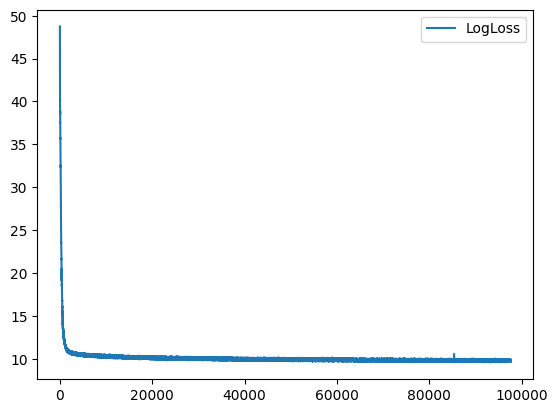

9.818426132202148


In [61]:
plt.plot(logLoss,label="LogLoss")
plt.legend()
plt.show()

print(logLoss[-1])

In [64]:
torch.save({
    "cnf": CNFModel.state_dict(),
    "optimizer": flowOptim.state_dict(),
}, "CNF_params_Optim.pth")
